# Effect of Varying Lanczos Degree in SLQ Method (Analytic Matrix)


### Objective

To observe the effect of varying Lanczos degree in computing $\mathrm{trace}(\mathbf{A}^{-1})$ using SLQ algorithm.

Matrix $\mathbf{A}$ is a sparse 3-band matrix with known analytic traceinv. Matrix size is fixed.

This notebook will plot

* Process time of each method.
* Accuracy of computing traceinv when compared with analytic solution for this matrix.

### Matrix

Matrix $\mathbf{A} = \mathbf{C}^{\intercal} \mathbf{C}$ is a symmetric 3-band matrix and $\mathbf{C}$ is a 2-band matrix defined by

$$
    C_{ij} = 
    \begin{cases}
        \alpha, & i = j, \\
        \beta, & i+1 = j.
    \end{cases}
$$

The analytic value of $\mathrm{trace}(\mathbf{A}^{-1})$ is known by

$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - q^2 \frac{q^{2n} - 1}{q^2 - 1} \right),
$$
where $n$ is the size of the matrix and $q = \beta / \alpha \neq 1$. If $n \gg 1$
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{1}{\alpha^2 - \beta^2} \left( n - \frac{q^{2}}{1 - q^2} \right).
$$
If $q = 1$, then
$$
    \mathrm{trace}(\mathbf{A}^{-1}) = \frac{n (n+1)}{2 \alpha^2}.
$$

### Consideratons

**parameters:**
* $\alpha = 2$, $\beta = 1$
* In SLQ method, `min_num_samples` and `max_num_samples` are fixed to 200.
* All 24 cores of Intel Xeon E5-2670 v3 processor are used for all algorithms.
* Each result is repeated 10 times and the wall time is averaged between these 10 repeats. However, only the last repeat is used to store the value of traceinv. This is becase if we average traceinv between these repeats, the number of samples would be 10*200, not 200. But, we onlt want to show the error of traceinv for 200 samples.
* The results of all three methods are compared with the analytic value of traceinv given in the above.

**Notes:**

* Matrix is generated as sparse CSR.
* Only 64-bit data type is used.

### How to run the code

#### 1. Run locally

Run `/benchmark/scripts/vary_lanczos_degree_analytic_matrix.py` by

    cd /benchmark/scripts
    python ./vary_lanczos_degree_analytic_matrix.py -o -n
    
Options `-o` and `-n` respectively produce results with and without orthogonalization during Lanczos iterations.

The outputs are stored in

* `/benchnmark/pickle_results/vary_lanczos_degree_analytic_matrix_ortho.pickle` for using orthogonalization.
* `/benchnmark/pickle_results/vary_lanczos_degree_analytic_matrix_not_ortho.pickle` for not using orthogonalization.

#### 2. Run on cluster

To run on a cluster with SLURM:

    cd jobfiles
    sbatch jobfile_vary_lanczos_degree_analytic_matrix.sh
   
When submitting the jobs on savio, make sure that the cpu is the same as the previous runs. Nodes on savio2 between `n027` and `n150` are *Intel Xeon E5-2670 v3*.

To run on a cluster with TORQUE:

    cd jobfiles
    qsub jobfile_vary_lanczos_degree_analytic_matrix.pbs

The above jobfile runs an array of 2 jobs on 2 nodes, with and without ortho option, and produces:

* `vary_lanczos_degree_analytic_matrix_ortho.pickle`
* `vary_lanczos_degree_analytic_matrix_not_ortho.pickle`

### Notes

If matrix is dense:

* Slope of elapsed time and process time is close to 1.
* Wall elapsed time of ortho is higher than non-ortho.
* In sontrast, CPU process time of ortho is less than non-ortho.
    
If matrix is sparse:

* Slope of elapsed time and process time is close to 2 (unlike the dense matrix).
* Wall elapsed time of ortho is higher than non-ortho.
* CPU process time of ortho is higher than non-ortho. (unlike the dense matrix).

In [1]:
import numpy
import numpy.polynomial.polynomial as poly
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#matplotlib.font_manager._rebuild() 
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

# Plot savefig settings
extension = 'png'
transparent=True
dpi = 500

#matplotlib.rcParams['text.antialiased'] = True
#matplotlib.rcParams['lines.antialiased'] = True
#matplotlib.rcParams['patch.antialiased'] = True

In [2]:
benchmark_dir = '..'
ortho_results_filename = join(benchmark_dir, 'pickle_results',
                              'vary_lanczos_degree_analytic_matrix_ortho.pickle')
not_ortho_results_filename = join(benchmark_dir, 'pickle_results',
                                  'vary_lanczos_degree_analytic_matrix_not_ortho.pickle')

with open(ortho_results_filename, 'rb') as ortho_file:
    benchmark_result_ortho = pickle.load(ortho_file)
with open(not_ortho_results_filename, 'rb') as not_ortho_file:
    benchmark_result_not_ortho = pickle.load(not_ortho_file)
    
print('Config ortho:')
pp.pprint(benchmark_result_ortho['config'])
print('Config not ortho:')
pp.pprint(benchmark_result_not_ortho['config'])
print('')
print('Matrix ortho:')
pp.pprint(benchmark_result_ortho['matrix'])
print('Matrix not ortho:')
pp.pprint(benchmark_result_not_ortho['matrix'])
print('')
print('Devices ortho:')
pp.pprint(benchmark_result_ortho['devices'])
print('Devices not ortho:')
pp.pprint(benchmark_result_not_ortho['devices'])

print('')
ortho_data_results = benchmark_result_ortho['data_results']['orthogonalize']
print('num data: %d' % len(ortho_data_results))
not_ortho_data_results = benchmark_result_not_ortho['data_results']['not-orthogonalize']
print('num data: %d' % len(not_ortho_data_results))

Config ortho:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'lanczos_degree': array([  10,   11,   13,   16,   18,   22,   25,   30,   35,   41,   48,
         57,   67,   78,   92,  108,  126,  148,  174,  204,  239,  280,
        329,  385,  452,  529,  621,  727,  853, 1000]),
    'lanczos_tol': None,
    'max_num_samples': 200,
    'min_num_samples': 200,
    'num_repeats': 20,
    'num_threads': 0,
    'orthogonalize': [-1],
    'outlier_significance_level': 0.01,
    'plot': False,
    'solver_tol': 1e-06,
    'symmetric': True,
    'verbose': False}
Config not ortho:
{   'confidence_level': 0.95,
    'error_atol': 0,
    'error_rtol': 0.001,
    'exponent': 1,
    'lanczos_degree': array([  10,   11,   13,   16,   18,   22,   25,   30,   35,   41,   48,
         57,   67,   78,   92,  108,  126,  148,  174,  204,  239,  280,
        329,  385,  452,  529,  621,  727,  853, 1000]),
    'lanczos_tol': None,
    'max_num_samples'

In [3]:
## Get data from list of dictionaries

# Remove some data
not_ortho_data_results_ = not_ortho_data_results.copy()
ortho_data_results_ = ortho_data_results.copy()

#remove_indices = [0, 1, 2]
remove_indices = []

for index in remove_indices[::-1]:
    del not_ortho_data_results_[index]
    del ortho_data_results_[index]

# Initialize arrays
num_data_ortho = len(ortho_data_results_)
num_data_not_ortho = len(not_ortho_data_results_)
ortho_tot_wall_time = numpy.zeros((num_data_ortho, ), dtype=float)
ortho_alg_wall_time = numpy.zeros((num_data_ortho, ), dtype=float)
ortho_cpu_proc_time = numpy.zeros((num_data_ortho, ), dtype=float)
not_ortho_tot_wall_time = numpy.zeros((num_data_not_ortho, ), dtype=float)
not_ortho_alg_wall_time = numpy.zeros((num_data_not_ortho, ), dtype=float)
not_ortho_cpu_proc_time = numpy.zeros((num_data_not_ortho, ), dtype=float)
ortho_trace = numpy.zeros((num_data_ortho, ), dtype=float)
not_ortho_trace = numpy.zeros((num_data_not_ortho, ), dtype=float)
ortho_error = numpy.zeros((num_data_ortho, ), dtype=float)
not_ortho_error = numpy.zeros((num_data_not_ortho, ), dtype=float)
lanczos_degree_ortho = numpy.zeros((num_data_ortho, ), dtype=float)
lanczos_degree_not_ortho = numpy.zeros((num_data_not_ortho, ), dtype=float)

for data_index in range(num_data_ortho):

    ortho_result = ortho_data_results_[data_index]

    ortho_tot_wall_time[data_index] = numpy.mean(ortho_result['info']['time']['tot_wall_time'])
    ortho_alg_wall_time[data_index] = numpy.mean(ortho_result['info']['time']['alg_wall_time'])
    ortho_cpu_proc_time[data_index] = numpy.mean(ortho_result['info']['time']['cpu_proc_time'])
    
    #ortho_trace[data_index] = ortho_result['trace'][-1]
    #ortho_error[data_index] = ortho_result['info']['error']['absolute_error'][-1]
    
    ortho_trace[data_index] = numpy.mean(ortho_result['trace'])
    ortho_error[data_index] = numpy.mean(ortho_result['info']['error']['absolute_error'])  
    lanczos_degree_ortho[data_index] = ortho_result['info']['solver']['lanczos_degree']
    
for data_index in range(num_data_not_ortho):

    not_ortho_result = not_ortho_data_results_[data_index]

    not_ortho_tot_wall_time[data_index] = numpy.mean(not_ortho_result['info']['time']['tot_wall_time'])
    not_ortho_alg_wall_time[data_index] = numpy.mean(not_ortho_result['info']['time']['alg_wall_time'])
    not_ortho_cpu_proc_time[data_index] = numpy.mean(not_ortho_result['info']['time']['cpu_proc_time'])
    
    #not_ortho_trace[data_index] = not_ortho_result['trace'][-1]
    #not_ortho_error[data_index] = not_ortho_result['info']['error']['absolute_error'][-1]
    
    not_ortho_trace[data_index] = numpy.mean(not_ortho_result['trace'])
    not_ortho_error[data_index] = numpy.mean(not_ortho_result['info']['error']['absolute_error'])
    lanczos_degree_not_ortho[data_index] = not_ortho_result['info']['solver']['lanczos_degree']
    
# Set what should be the x axis of both original and the twin plot
# All variables will be sorted by this variable in oncreasing order
sorting_index = numpy.argsort(lanczos_degree_ortho)
lanczos_degree_ortho = lanczos_degree_ortho[sorting_index]
ortho_tot_wall_time = ortho_tot_wall_time[sorting_index]
ortho_alg_wall_time = ortho_alg_wall_time[sorting_index]
ortho_cpu_proc_time = ortho_cpu_proc_time[sorting_index]
ortho_trace = ortho_trace[sorting_index]
ortho_error = ortho_error[sorting_index]

sorting_index = numpy.argsort(lanczos_degree_not_ortho)
lanczos_degree_not_ortho = lanczos_degree_not_ortho[sorting_index]
not_ortho_tot_wall_time = not_ortho_tot_wall_time[sorting_index]
not_ortho_alg_wall_time = not_ortho_alg_wall_time[sorting_index]
not_ortho_cpu_proc_time = not_ortho_cpu_proc_time[sorting_index]
not_ortho_trace = not_ortho_trace[sorting_index]
not_ortho_error = not_ortho_error[sorting_index]

# Which variable to plot
# Note: Wall elapsed time of ortho is higher than non-ortho. But, CPU process time of ortho is less!!
# than non-ortho.
ordinate_ortho0 = ortho_alg_wall_time
ordinate_not_ortho0 = not_ortho_alg_wall_time
ordinate_ortho1 = ortho_cpu_proc_time
ordinate_not_ortho1 = not_ortho_cpu_proc_time

In [4]:
def find_slope(x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    return numpy.polyfit(log2_x, log2_y, 1)[0]


def line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    coefs = poly.polyfit(x, y, 1)
    yi = poly.polyval(xi, coefs)
    
    return yi


def log_line_fit(xi, x, y):
    """
    finds a in y = x**a
    """
    
    log2_x = numpy.log2(x)
    log2_xi = numpy.log2(xi)
    log2_y = numpy.log2(y)
    
    coefs = poly.polyfit(log2_x, log2_y, 1)
    log2_yi = poly.polyval(log2_xi, coefs)
    
    return 2**log2_yi


def analytic_traceinv(matrix):
    """
    Analytic trace of inverse of banded matrix.
    """
    
    sizes = matrix['size']
    alpha = matrix['band_alpha']
    beta = matrix['band_beta']
    symmetric = matrix['symmetric']
    
    is_scalar = False
    if numpy.isscalar(sizes):
        sizes = numpy.array([sizes])
        is_scalar = True
    
    if symmetric:
        
        if alpha == beta:
            M_traceinv = sizes * (sizes+1) / (2.0 * alpha**2)
        else:
            q = beta / alpha
            M_traceinv = numpy.zeros((sizes.size), dtype=float)
            
            for i in range(sizes.size):
                if sizes[i] < 200:
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * \
                        ( sizes - (q**2) *((q**(2.0*sizes) - 1.0) / (q**2 - 1.0)))
                else:
                    # Using assymptitic approximation of large sums
                    M_traceinv = (1.0 / (alpha**2 - beta**2)) * ( sizes - ((q**2) / (1.0 - q**2)))
            
    else:
        M_traceinv = sizes / alpha
        
    if is_scalar:
        return M_traceinv[0]
    else:
        return M_traceinv

Plot saved to "vary_lanczos_degree_analytic_matrix_time.png".


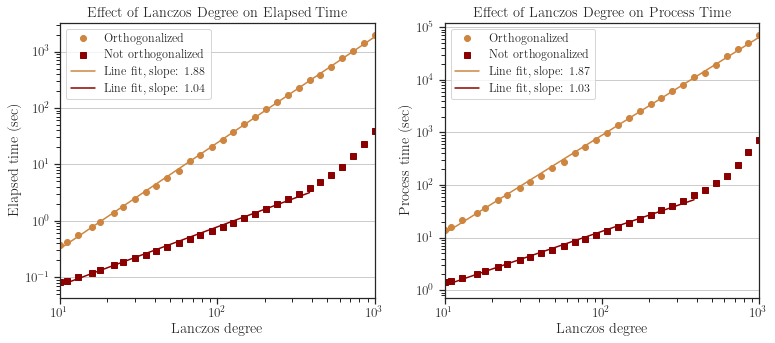

In [5]:
# Slopes
#indices = numpy.arange(0, 11)
indices_ortho = numpy.arange(0, lanczos_degree_ortho.size)
slope_ortho0 = find_slope(lanczos_degree_ortho[indices_ortho], ordinate_ortho0[indices_ortho])
slope_ortho1 = find_slope(lanczos_degree_ortho[indices_ortho], ordinate_ortho1[indices_ortho])

indices_not_ortho = numpy.arange(0, lanczos_degree_not_ortho.size-6)
slope_not_ortho0 = find_slope(lanczos_degree_not_ortho[indices_not_ortho], 
                             ordinate_not_ortho0[indices_not_ortho])
slope_not_ortho1 = find_slope(lanczos_degree_not_ortho[indices_not_ortho], 
                             ordinate_not_ortho1[indices_not_ortho])

# Interpolation
lanczos_degree_ortho_i = numpy.logspace(numpy.log10(lanczos_degree_ortho[indices_ortho[0]]),
                                        numpy.log10(lanczos_degree_ortho[indices_ortho[-1]]), 100)
lanczos_degree_not_ortho_i = numpy.logspace(numpy.log10(lanczos_degree_not_ortho[indices_not_ortho[0]]),
                                            numpy.log10(lanczos_degree_not_ortho[indices_not_ortho[-1]]), 100)
ordinate_ortho_i0 = log_line_fit(lanczos_degree_ortho_i, lanczos_degree_ortho[indices_ortho],
                                 ordinate_ortho0[indices_ortho])
ordinate_ortho_i1 = log_line_fit(lanczos_degree_ortho_i, lanczos_degree_ortho[indices_ortho],
                                 ordinate_ortho1[indices_ortho])
ordinate_not_ortho_i0 = log_line_fit(lanczos_degree_not_ortho_i,
                                     lanczos_degree_not_ortho[indices_not_ortho],
                                     ordinate_not_ortho0[indices_not_ortho])
ordinate_not_ortho_i1 = log_line_fit(lanczos_degree_not_ortho_i,
                                     lanczos_degree_not_ortho[indices_not_ortho],
                                     ordinate_not_ortho1[indices_not_ortho])
        
## Plotting Elapsed time vs lanczos_degree
fig, ax = plt.subplots(ncols=2, figsize=(11, 5))

color_ortho = 'peru'
color_not_ortho = 'darkred'
    
ax[0].plot(lanczos_degree_ortho, ordinate_ortho0, 'o', color=color_ortho, label='Orthogonalized')
ax[0].plot(lanczos_degree_not_ortho, ordinate_not_ortho0, 's', color=color_not_ortho,
           label='Not orthogonalized')
ax[0].plot(lanczos_degree_ortho_i, ordinate_ortho_i0, '-', color=color_ortho,
           label='Line fit, slope: %0.2f' % slope_ortho0)
ax[0].plot(lanczos_degree_not_ortho_i, ordinate_not_ortho_i0, '-', color=color_not_ortho,
           label='Line fit, slope: %0.2f' % slope_not_ortho0)

ax[1].plot(lanczos_degree_ortho, ordinate_ortho1, 'o', color=color_ortho, label='Orthogonalized')
ax[1].plot(lanczos_degree_not_ortho, ordinate_not_ortho1, 's', color=color_not_ortho,
           label='Not orthogonalized')
ax[1].plot(lanczos_degree_ortho_i, ordinate_ortho_i1, '-', color=color_ortho,
           label='Line fit, slope: %0.2f' % slope_ortho1)
ax[1].plot(lanczos_degree_not_ortho_i, ordinate_not_ortho_i1, '-', color=color_not_ortho,
           label='Line fit, slope: %0.2f' % slope_not_ortho1)
        
# create blank rectangle
#extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles0,labels0 = ax[0].get_legend_handles_labels()
handles1,labels1 = ax[1].get_legend_handles_labels()
#handles = [extra, extra, extra, extra,
#           extra, handles[0], handles[2], handles[4], 
#           extra, handles[1], handles[3], extra]
#labels = ["", "32 bit", "64 bit", "128 bit",
#          "no BLAS", "", "", "",
#          "BLAS", "", "", ""]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2)
ax[0].legend(handles0, labels0, loc='upper left', ncol=1, fontsize='small')
ax[1].legend(handles1, labels1, loc='upper left', ncol=1, fontsize='small')
#ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)
    
ax[0].set_xscale('log', base=10)
ax[0].set_yscale('log', base=10)
ax[1].set_xscale('log', base=10)
ax[1].set_yscale('log', base=10)
#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=0, xmax=100))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(lanczos_degree)
ax[0].set_xlim([numpy.min([lanczos_degree_ortho[0], lanczos_degree_not_ortho[0]]),
             numpy.max([lanczos_degree_ortho[-1], lanczos_degree_not_ortho[-1]])])
ax[1].set_xlim([numpy.min([lanczos_degree_ortho[0], lanczos_degree_not_ortho[0]]),
             numpy.max([lanczos_degree_ortho[-1], lanczos_degree_not_ortho[-1]])])

#ax.set_ylabel('Elapsed time (relative to 32-bit no BLAS)')
#ax.set_ylabel('Process time (sec)')
ax[0].set_ylabel('Elapsed time (sec)')
ax[1].set_ylabel('Process time (sec)')
#ax.set_title('Elapsed Time v.s. Matrix Size')
ax[0].set_title('Effect of Lanczos Degree on Elapsed Time')
ax[1].set_title('Effect of Lanczos Degree on Process Time')
ax[0].set_xlabel('Lanczos degree')
ax[1].set_xlabel('Lanczos degree')
ax[0].grid(axis='y')
ax[1].grid(axis='y')

plt.tight_layout()

# Save plot
save_dir = 'svg_plots'
filename_svg = 'vary_lanczos_degree_analytic_matrix_time' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))

Plot saved to "vary_lanczos_degree_analytic_matrix_accuracy.png".


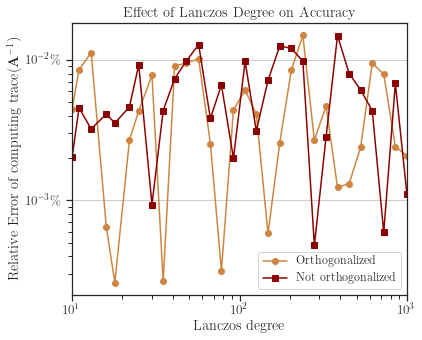

In [6]:
# Plotting Lanczos degree vs Accuracy

trace_ortho = analytic_traceinv(benchmark_result_ortho['matrix'])
trace_not_ortho = analytic_traceinv(benchmark_result_not_ortho['matrix'])

relative_error_ortho = numpy.zeros((num_data_ortho, ), dtype=float)
relative_error_not_ortho = numpy.zeros((num_data_not_ortho, ), dtype=float)

relative_error_ortho = 100.0 * numpy.abs(ortho_trace - trace_ortho) / trace_ortho
relative_error_not_ortho = 100.0 * numpy.abs(not_ortho_trace - trace_not_ortho) / trace_not_ortho

fig, ax = plt.subplots(figsize=(6, 5))
    
ax.plot(lanczos_degree_ortho, relative_error_ortho, '-o', color=color_ortho, label='Orthogonalized')
ax.plot(lanczos_degree_not_ortho, relative_error_not_ortho, '-s', color=color_not_ortho, label='Not orthogonalized')
        
# create blank rectangle
#extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
handles,labels = ax.get_legend_handles_labels()
#handles = [extra, extra, extra, extra,
#           extra, handles[0], handles[2], handles[4], 
#           extra, handles[1], handles[3], extra]
#labels = ["", "32 bit", "64 bit", "128 bit",
#          "no BLAS", "", "", "",
#          "BLAS", "", "", ""]

#ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left', ncol=3, handletextpad = -2)
ax.legend(handles, labels, loc='lower right', ncol=1, fontsize='small')
#ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=3, handletextpad = -2)
    
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
#ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=3, xmax=100))
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: '$10^{%d}\%%$' % numpy.log10(x)))

#ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax.get_xaxis().get_major_formatter().labelOnlyBase = False
#ax.set_xticks(lanczos_degree_not_ortho)
ax.set_xlim([numpy.min([lanczos_degree_ortho[0], lanczos_degree_not_ortho[0]]),
             numpy.max([lanczos_degree_ortho[-1], lanczos_degree_not_ortho[-1]])])

#ax.set_ylabel('Elapsed time (relative to 32-bit no BLAS)')
ax.set_ylabel('Relative Error of computing $\mathrm{trace}(\mathbf{A}^{-1})$')
#ax.set_title('Elapsed Time v.s. Matrix Size')
ax.set_title('Effect of Lanczos Degree on Accuracy')
ax.set_xlabel('Lanczos degree')
ax.grid(axis='y')

# Save plot
save_dir = 'svg_plots'
filename_svg = 'vary_lanczos_degree_analytic_matrix_accuracy' + '.' + extension
plt.savefig(join(benchmark_dir, save_dir, filename_svg), transparent=transparent, bbox_inches='tight',
            dpi=dpi)
print('Plot saved to "%s".' % (filename_svg))